# Yemen NTL Trends

1.	Pull and process NTL imagery for all of Yemen, from January 2021 through latest available. 
2.	Create 2 line charts, tracking monthly percent change (or other normalized index) of NTL by admin-level 1 (governorate), with markers for the period from 4/2022 to 10/2022, and another chart, with just two lines, for aggregated North (Houthis) and South (IRG) admin-1s. 
3.	Prepare a table with the raw data, that the team can use for further analysis and indexing. 


## Pull Data Sources

In [1]:
import os, sys
from os.path import join, expanduser
from gadm import GADMDownloader
import ee
import geopandas as gpd
import pandas as pd
from gee_zonal import ZonalStats, gee_helpers
from glob import glob

In [2]:
# ee.Authenticate()
# sys.path.append(join(expanduser('~'), 'Repos_45VFZW2', 'GEE_Zonal', 'src'))
# from gee_zonal import ZonalStats, gee_helpers

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format, comma_format
import plotnine
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import folium as flm

## Merge Control Areas

In [10]:
data_dir = join(expanduser("~"), 'data')
output_dir = join(expanduser("~"), 'output', 'yem')
control_gdfs = [gpd.read_file(f).assign(group=os.path.basename(f).split('.')[0]) for f in glob(join(data_dir, 'control_areas', '*.shp'))]
control_gdfs[-1].set_crs('EPSG:9707', inplace=True)

,Id,geometry,group
0,0,"POLYGON ((45.96411 14.32770, 45.93048 14.35931...",DFA Expanded
1,0,"POLYGON ((45.51727 14.83069, 45.48810 14.80487...",DFA Expanded


In [74]:
control = pd.concat(control_gdfs)

In [75]:
control = control.to_crs("EPSG:4326")

In [76]:
control.group.unique()

array(['IRG', 'AQAP Presence', 'De-facto_authority_(DFA)', 'STC',
       'DFA Expanded'], dtype=object)

In [14]:
m = control.explore(
    column='group',
    tooltip="group",
    # cmap="YlOrRd",
    # scheme='naturalbreaks',
    # legend_kwds=dict(colorbar=True, caption='Frequency IPC 3+', interval=True),
    name="Control Areas",
    # tiles="Stamen Toner"
)
flm.LayerControl().add_to(m)
m

In [77]:
control.loc[control.group=="De-facto_authority_(DFA)", "group"] = "De-facto Authority (DFA)"
control.loc[control.group=="DFA Expanded", "group"] = "De-facto Authority (DFA)"
# control.loc[control.group=="AQAP Presence", "group"] = "IRG" # AQAP
# control.loc[control.group=="STC", "group"] = "IRG"

In [78]:
control_dissolved = control[['geometry', 'group']].dissolve(by="group")
control_dissolved.reset_index(inplace=True)

In [79]:
control_dissolved.loc[:, "geometry"] = control_dissolved.buffer(0.001)

/tmp/ipykernel_445677/4283242573.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_445677/4283242573.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [83]:
control_dissolved = control_dissolved.loc[control_dissolved.group.isin(['De-facto Authority (DFA)', 'IRG'])].copy()

In [84]:
m = control_dissolved.explore(
    column='group',
    tooltip="group",
    # cmap="YlOrRd",
    # scheme='naturalbreaks',
    # legend_kwds=dict(colorbar=True, caption='Frequency IPC 3+', interval=True),
    name="Control Areas",
    # tiles="Stamen Toner"
)
# gadm1.explore(
#     m = m,
#     # column='file_name',
#     # tooltip="file_name",
#     # cmap="YlOrRd",
#     # scheme='naturalbreaks',
#     # legend_kwds=dict(colorbar=True, caption='Frequency IPC 3+', interval=True),
#     name="Adm1",
#     # tiles="Stamen Toner"
# )
flm.LayerControl().add_to(m)
m

In [85]:
control_dissolved.geometry.is_valid

1    True
2    True
dtype: bool

In [86]:
# aoi_control = geopandas_to_ee(control_dissolved)
aoi_control = gee_helpers.gpd_to_gee(control_dissolved)

## Pull NTL for control areas

In [87]:
start = "2018-01-01"
end = "2023-05-01"

In [88]:
# plotnine.options.figure_size = (12, 12)

### Interpolate pixels with missing data due to clouds

In [89]:
def smoothenViirs(collection, window_size):

    def prepareImage(img):
        rad = img.select('avg_rad')
        cf_cvg = img.select('cf_cvg')
        cf_eq0 = cf_cvg.gt(0)
        img_masked = rad.mask(cf_eq0)

        date = img.date()
        # add a time variable
        months = date.difference(ee.Date('1970-01-01'), 'month')
        return img_masked.addBands(ee.Image(months).rename('time')).float()

    def smoother(t):
        # helper function to apply linear regression equation
        def applyFit(img):
            return img.select('time').multiply(fit.select('scale')) \
                    .add(fit.select('offset')) \
                    .set('system:time_start',img.get('system:time_start')) \
                    .rename('avg_rad')
        
        t = ee.Date(t)
        
        window = data.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month'))
        
        fit = window.select(['time','avg_rad']) \
            .reduce(ee.Reducer.linearFit())
        
        return window.map(applyFit).toList(10)
    
    # function to reduce time stacked linear regression results
    # requires that a variable 'fitIC' exists from the smoother function
    def reduceFits(t):
        t = ee.Date(t)
        return fitIC.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month')) \
                  .mean().set('system:time_start',t.millis()).rename('avg_rad')
    
    def replace(original):
        date = original.date()
        smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
        smooth = smoothed_sel.first()
        return smooth.where(original, original)
    
    data = collection \
        .map(prepareImage)
    
    # get unique dates
    dates = ee.List(data.aggregate_array('system:time_start'))
    
    fitIC = ee.ImageCollection(dates.map(smoother).flatten())
    
    smoothed = ee.ImageCollection(dates.map(reduceFits))
    
    collection_fill = data.select('avg_rad').map(replace)
    return collection_fill

In [90]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('avg_rad').filterDate(start, end) # VCMSLCFG
viirs_copy = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterDate(start, end)
viirs_interpolated = smoothenViirs(viirs_copy, 3)

In [91]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi_control,
    statistic_type= 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs
)
res = zs.runZonalStats()
df_ee = res.copy()

def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df_ee.rename(rename_func, axis=1, inplace=True)
df_ee = pd.wide_to_long(
    df_ee,
    stubnames = ['rad'],
    i = 'group',
    j = 'date',
    sep = "__"
)
df_ee.reset_index(inplace=True)
df_ee.loc[:,"ym"] = pd.to_datetime(df_ee.date, format="%Y%m%d")

In [92]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi_control,
    statistic_type= 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs_interpolated
)
res = zs.runZonalStats()
df_ee_int = res.copy()

def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df_ee_int.rename(rename_func, axis=1, inplace=True)
df_ee_int = pd.wide_to_long(
    df_ee_int,
    stubnames = ['rad'],
    i = 'group',
    j = 'date',
    sep = "__"
)
df_ee_int.reset_index(inplace=True)
df_ee_int.loc[:,"ym"] = pd.to_datetime(df_ee_int.date, format="%Y%m%d")

In [93]:
df_ee_int.rename(columns={"rad":"rad_int"}, inplace=True)

In [94]:
df = df_ee.merge(df_ee_int[['group', 'ym', 'rad_int']], on=['group', 'ym'], how='left', validate='1:1')

In [95]:
df.loc[:, "month"] = df.ym.dt.month
df.loc[:, "year"] = df.ym.dt.year

In [96]:
df.head()

,group,date,rad,ym,rad_int,month,year
0,De-facto Authority (DFA),20180101,48753.022691,2018-01-01,49349.750490,1,2018
1,IRG,20180101,213386.418479,2018-01-01,214864.093254,1,2018
2,De-facto Authority (DFA),20180201,69581.579231,2018-02-01,70015.325110,2,2018
3,IRG,20180201,258582.420413,2018-02-01,257795.191597,2,2018
4,De-facto Authority (DFA),20180301,109040.743955,2018-03-01,109518.573671,3,2018


In [97]:
df.to_csv(join(output_dir, 'control_viirs_ee.csv'), index=False)

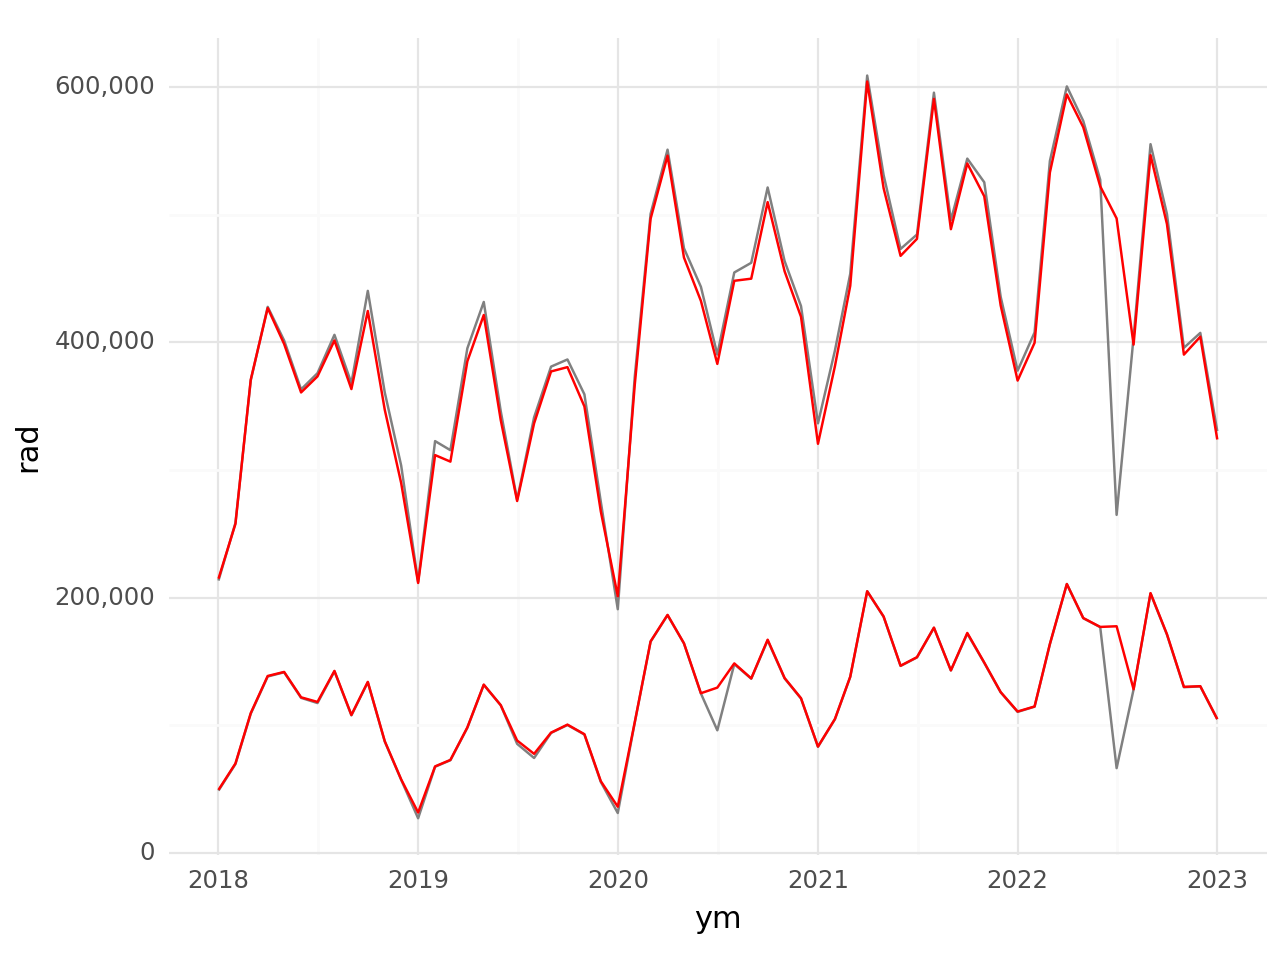

<Figure Size: (640 x 480)>

In [98]:
(
ggplot(df, aes(x="ym", y="rad", group="group", color="group")) #
    + geom_line(alpha=1, color="gray")
    + geom_line(aes(x="ym", y="rad_int", group="group"), color="red")
    # + labs(
    #     x="", y="% of pop", title="Population Access to Health Facilities by Wealth Quintile",
    #     fill="Within 2 h
    # )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))
    + scale_y_continuous(labels=comma_format())
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    # + facet_wrap("~group", scales = "free", ncol=3)
)

## Calculate reference values

In [110]:
def calculate_ref(period):
    if period==2021:
        df_ref = df.loc[df.year==2021,:].copy()
    else:
        df_ref = df.loc[df.year<2022,:].copy()
    
    df_ref = df_ref.groupby(["group", "month"])[['rad', 'rad_int']].mean().reset_index()
    df_ref.rename(columns={"rad":"rad_ref", "rad_int":"rad_int_ref"}, inplace=True)

    df_filt = df.merge(df_ref, on=["group", "month"], how="left", validate="m:1")
    df_filt = df_filt.loc[df_filt.ym>="2022-01-01",:].copy()
    df_filt.loc[:, "rad_int_pct"] = df_filt.rad_int / df_filt.rad_int_ref
    df_filt.loc[:, "rad_int_pct_ch"] = df_filt.apply(lambda x: (x.rad_int-x.rad_int_ref) / (x.rad_int_ref), axis=1)
    df_filt.loc[:, "direction"] = ""
    df_filt.loc[df_filt.rad_int_pct_ch<0, "direction"] = "decrease"
    df_filt.loc[df_filt.rad_int_pct_ch>0, "direction"] = "increase"

    return df_filt

In [111]:
df_historical_baseline = calculate_ref('historical')
df_2021_baseline = calculate_ref(2021)

In [99]:
# ref_period = 'all previous' # 2021 or all previous
# if ref_period==2021:
#     df_ref = df.loc[df.year==2021,:].copy()
# else:
#     df_ref = df.loc[df.year<2022,:].copy()

In [100]:
# df_ref = df_ref.groupby(["group", "month"])[['rad', 'rad_int']].mean().reset_index()
# df_ref.rename(columns={"rad":"rad_ref", "rad_int":"rad_int_ref"}, inplace=True)
# df_filt = df.merge(df_ref, on=["group", "month"], how="left", validate="m:1")
# df_filt = df_filt.loc[df_filt.ym>="2022-01-01",:].copy()
# df_filt.loc[:, "rad_int_pct"] = df_filt.rad_int / df_filt.rad_int_ref
# df_filt.loc[:, "rad_int_pct_ch"] = df_filt.apply(lambda x: (x.rad_int-x.rad_int_ref) / (x.rad_int_ref), axis=1)
# df_filt.loc[:, "direction"] = ""
# df_filt.loc[df_filt.rad_int_pct_ch<0, "direction"] = "decrease"
# df_filt.loc[df_filt.rad_int_pct_ch>0, "direction"] = "increase"


In [117]:
p1 = (
ggplot(df_historical_baseline, aes(x="ym", y="rad_int_pct_ch", group="group", color="group")) #
    + geom_line(alpha=1)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from monthly baseline (2018-2021)",
        color="Control Area", caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    # + facet_wrap("~group", scales = "fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    # + scale_color_manual(values=['#d73027', '#1a9850'])
    + theme(figure_size=(8, 6))
)
p1
p1.save(filename=join(output_dir, 'control-pct-change-historical.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/control-pct-change-historical.jpeg


In [120]:
p2 = (
ggplot(df_2021_baseline, aes(x="ym", y="rad_int_pct_ch", group="group", color="group")) #
    + geom_line(alpha=1)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from previous month (2021)",
        color="Control Area", caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    # + facet_wrap("~group", scales = "fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    # + scale_color_manual(values=['#d73027', '#1a9850'])
    + theme(figure_size=(8, 6))
)
# p2
p2.save(filename=join(output_dir, 'control-pct-change-2021.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/control-pct-change-2021.jpeg


In [122]:
p3 = (
ggplot(df_historical_baseline, aes(x="ym", y="rad_int_pct_ch", group="group", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from monthly baseline (2018-2021)",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~group", scales = "fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
    + theme(figure_size=(8, 6))
)
p3
p3.save(filename=join(output_dir, 'control-pct-change-historical-bar.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/control-pct-change-historical-bar.jpeg


In [124]:
p4 = (
ggplot(df_historical_baseline, aes(x="ym", y="rad_int_pct_ch", group="group", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from previous month (2021)",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~group", scales = "fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
    + theme(figure_size=(8, 6))
)
p4
p4.save(filename=join(output_dir, 'control-pct-change-2021-bar.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/control-pct-change-2021-bar.jpeg


In [125]:
p5 = (
ggplot(df.loc[df.year>=2021], aes(x="ym", y="rad_int", group="group", color="group")) #
    + geom_line(alpha=1)
    # + geom_line(aes(x="ym", y="rad_int_ref", group="NAME_1"), alpha=0.5, color="red")
    # + geom_hline(yintercept=0)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights, VIIRS",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('2 months'), labels=date_format('%y, %m'))
    + scale_y_continuous(labels=comma_format())
    + theme(legend_position='none')
    + facet_wrap("~group", scales = "free", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(figure_size=(8, 6))
    # + scale_color_manual(values=['#d73027', '#1a9850'], labels=['True', 'Monthly Reference'])
    # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
    # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
)
p5
p5.save(filename=join(output_dir, 'control-lights.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/control-lights.jpeg
